## Training ML models

Once you have explored the repository and selected an appropriate training dataset, you can download it and train a model. In this notebook we will show an example of how to do so using the [EuroSAT](https://www.eotdl.com/datasets/EuroSAT-RGB) dataset, in its RGB version.

In [1]:
from eotdl.datasets import download_dataset

path = download_dataset("EuroSAT-RGB", version=1, path="data", force=True)
path

100%|██████████| 90.3M/90.3M [00:05<00:00, 18.2MiB/s]
100%|██████████| 1/1 [00:05<00:00,  5.68s/file]


'data/EuroSAT-RGB/v1'

In [2]:
!unzip {path}/EuroSAT-RGB.zip -d data/train

Archive:  data/EuroSAT-RGB/v1/EuroSAT-RGB.zip
   creating: data/train/EuroSAT-RGB/
   creating: data/train/EuroSAT-RGB/Industrial/
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_1743.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_1273.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_1117.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_1121.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_1641.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_259.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_435.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_674.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_905.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_238.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_631.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_2292.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/

In order to streamline the training process, we will use the [PytorchEO](https://github.com/earthpulse/pytorchEO) library. This open source library is built on top of [Pytorch](https://pytorch.org/) and [Pytorch Lightning](https://lightning.ai/) to facilitate the design, implementation, training and deployment of deep learning models for Earth Observation. It offers AI-Ready EO datasets as well as ready-to-use tasks and models.

We can use the EuroSATRGB wrapper to pre-process the dataset, including the generation of classes, train/val/test splitting, etc. We plan to implement more wrappers for other datasets in the future, but feel free to contribute with your own (either to PytorchEO or any other library).

In [3]:
from pytorch_eo.datasets import EuroSATRGB

# do not set download to True since it will download the dataset from the original source and not EOTDL !

ds = EuroSATRGB(batch_size=25, verbose=True, path="data", download=False, data_folder='train/EuroSAT-RGB') 

ds.setup()

Number of images: 27000
Training samples 16200
Validation samples 5400
Test samples 5400


In [4]:
ds.df

,image,label
0,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_4...,0
1,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_2...,0
2,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_1...,0
3,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_1...,0
4,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_1...,0
...,...,...
26995,data/train/EuroSAT-RGB/SeaLake/SeaLake_1843.jpg,9
26996,data/train/EuroSAT-RGB/SeaLake/SeaLake_1516.jpg,9
26997,data/train/EuroSAT-RGB/SeaLake/SeaLake_2669.jpg,9
26998,data/train/EuroSAT-RGB/SeaLake/SeaLake_2734.jpg,9


This dataset contains 27000 Sentinel 2 images classified in 10 categories. 

In [5]:
ds.num_classes, ds.classes

(10,
 ['AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'])

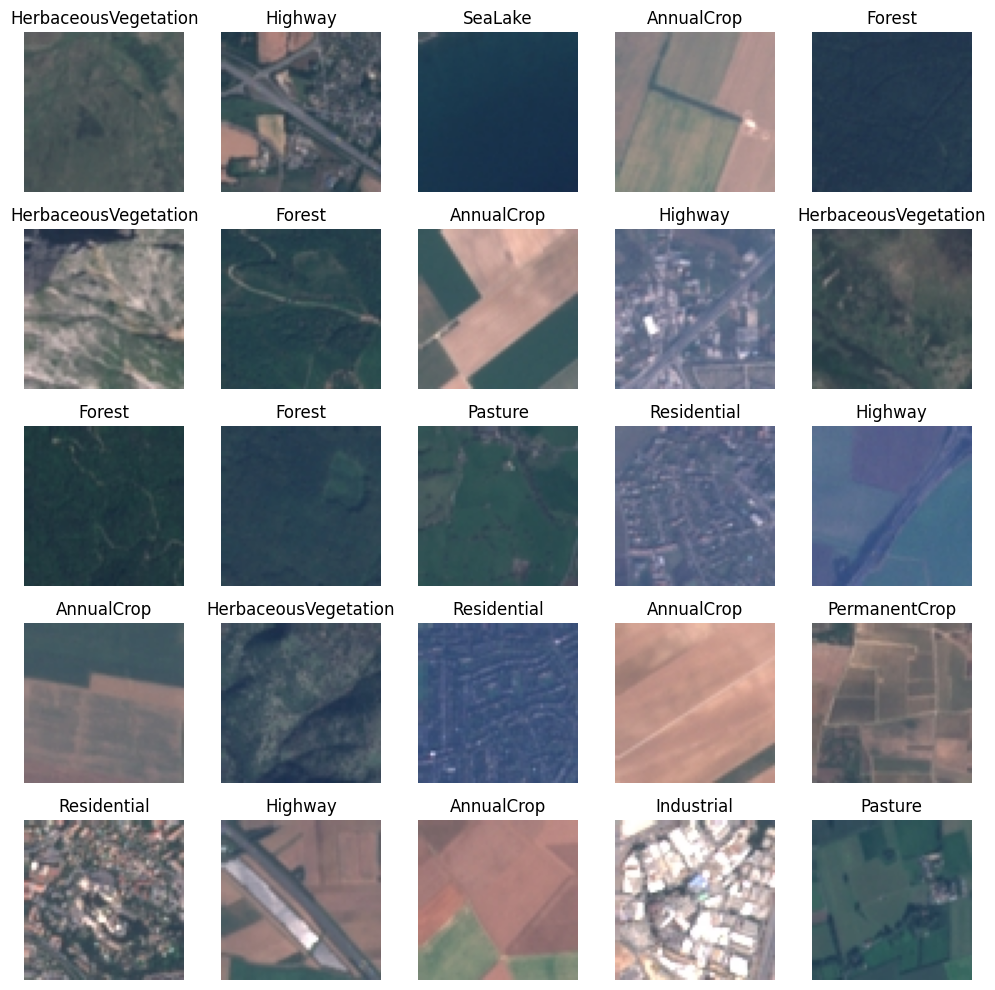

In [6]:
import matplotlib.pyplot as plt

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['label']

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

We will train a neural network for the task of Image classification.

In [7]:
import torch 
from pytorch_eo.tasks.classification import ImageClassification

task = ImageClassification(num_classes=ds.num_classes)

sample_inputs = torch.randn(8, 3, 224, 224)
output = task(sample_inputs)
output.shape

torch.Size([8, 10])

In [8]:
import lightning as L

trainer = L.Trainer(
    accelerator="cuda",
    devices=1,
    max_epochs=10,
	enable_checkpointing=False,
	# limit_train_batches=50,
	# limit_val_batches=50,
)

trainer.fit(task, ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/juan/miniconda3/envs/peo/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float3

Number of images: 27000
Training samples 16200
Validation samples 5400
Test samples 5400



  | Name    | Type               | Params
-----------------------------------------------
0 | model   | ResNet             | 11.2 M
1 | loss_fn | CrossEntropyLoss   | 0     
2 | acc     | MulticlassAccuracy | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/juan/miniconda3/envs/peo/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/juan/miniconda3/envs/peo/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Once the model is trained you can evaluate it using some test data.

In [9]:
from tqdm import tqdm 

task.eval()
acc = 0
with torch.no_grad():
	for batch in tqdm(ds.test_dataloader()):
		output = task(batch['image'])
		acc += (output.argmax(1) == batch['label']).sum().item()

print("test accuracy: ", f'{acc}/{len(ds.test_dataloader().dataset)}')

100%|██████████| 216/216 [00:06<00:00, 35.48it/s]

test accuracy:  3821/5400


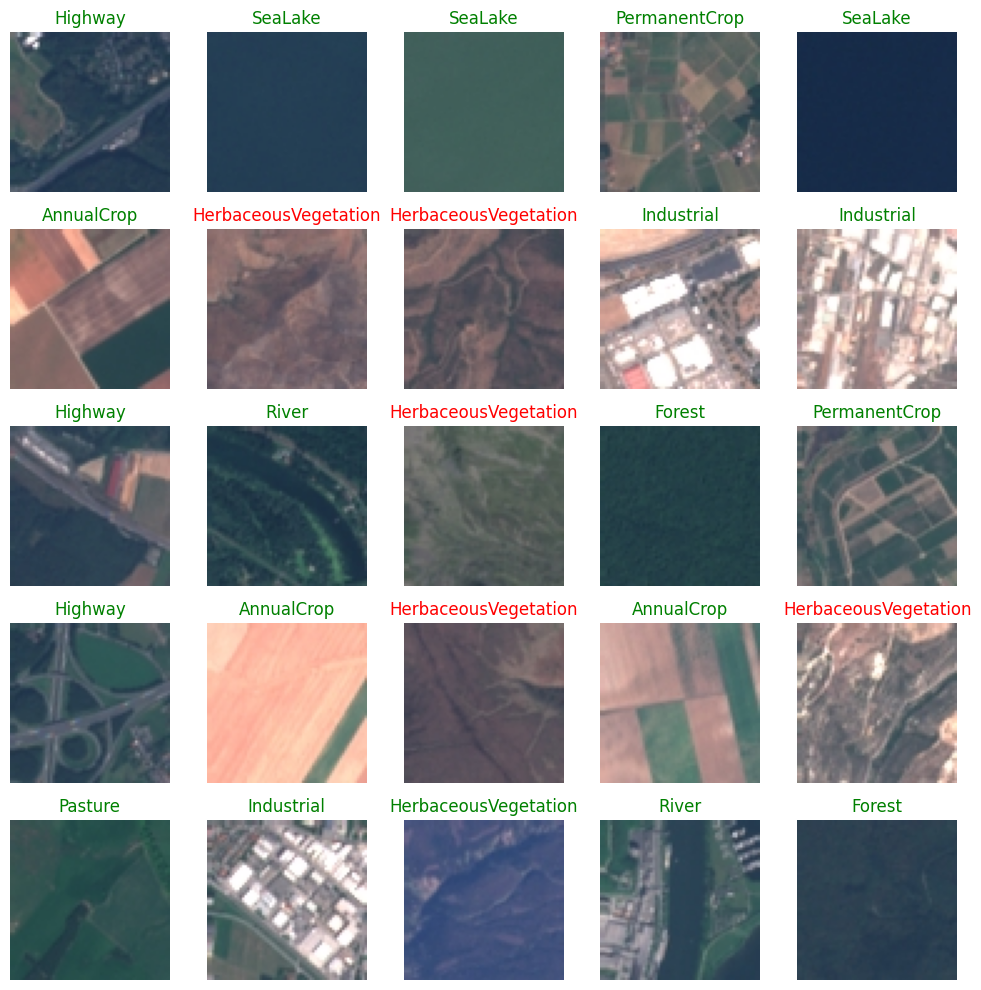

In [10]:
# extract batch from test dataloader

batch = next(iter(ds.test_dataloader(shuffle=True, batch_size=25)))
imgs, labels = batch['image'], batch['label']

# compute predictions

preds = task.predict(batch)
preds = torch.argmax(preds, axis=1)

# visualize predictions

fig = plt.figure(figsize=(10, 10))
for i, (img, label, pred) in enumerate(zip(imgs, labels, preds)):
	ax = plt.subplot(5, 5, i + 1)
	ax.imshow(img.permute(1,2,0))
	gt = ds.classes[label.item()]
	pred = ds.classes[pred.item()]
	ax.set_title(gt, color="green" if gt == pred else 'red')
	ax.axis('off')
plt.tight_layout()
plt.show()

And export it to later ingestion to the EOTDL. You can choose your preferred export method, here we use ONNX.

In [11]:
# !pip install onnx onnxruntime

In [17]:
import os

filepath = "data/EuroSAT-RGB-model/model.onnx"
os.makedirs(os.path.dirname(filepath), exist_ok=True)

task.to_onnx(
	filepath, 
	imgs, 
	export_params=True, 
	input_names=['input'],
	output_names=['output'],
	dynamic_axes={
		'input': {
			0: 'batch_size',
			2: 'height',
			3: 'width'
		}, 
		'output': {
			0: 'batch_size'
		}
	}
)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [18]:
import onnxruntime
import numpy as np

x = np.random.randn(3, 3, 132, 412).astype(np.float32)

ort_session = onnxruntime.InferenceSession(filepath)
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: x}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs[0].shape

(3, 10)

In [19]:
acc = 0
for batch in tqdm(ds.test_dataloader()):
	ort_inputs = {input_name: batch['image'].numpy()}
	ort_outs = ort_session.run(None, ort_inputs)
	acc += np.sum((ort_outs[0].argmax(1) == batch['label'].numpy()))

print("test accuracy: ", f'{acc}/{len(ds.test_dataloader().dataset)}')

100%|██████████| 216/216 [00:05<00:00, 36.94it/s]

test accuracy:  3821/5400


Finally, let's ingest the model.

In [20]:
text = """---
name: EuroSAT-RGB
authors: 
  - Juan B. Pedro
license: open
source: https://github.com/earthpulse/eotdl/blob/develop/tutorials/workshops/philab24/02_training.ipynb
---

# EuroSAT-RGB

This is a toy model trained with the EuroSAT dataset as part of the EOTDL tutorial norebooks.
"""

with open('data/EuroSAT-RGB-model/README.md', 'w') as outfile:
	outfile.write(text)

> The ingestion will fail if the model already exists or no new version is generated.

In [24]:
from eotdl.models import ingest_model

ingest_model("data/EuroSAT-RGB-model")

Uploading directory data/EuroSAT-RGB-model...
generating list of files to upload...


100%|██████████| 1/1 [00:00<00:00, 16.30it/s]


Exception: No new files to upload